# Regresión Logística Múltiple

**Tenga en cuenta que este script es una guía para ayudar en la resolución de los ejercicios. Las consignas, incisos, datasets, tablas, parámetros y/o demás valores utilizados pueden no coincidir con los de la práctica.**

---
**Montar la carpeta de Google Drive y definir constantes para trabajar**

In [ ]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '../Fuentes' # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = '../Datos/'  # carpeta donde se encuentran los datasets

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

Mounted at /content/drive/


**Ejercicio 9**

El archivo SEMILLAS.csv contiene información de granos que pertenecen a tres variedades diferentes de trigo.
Entrene una neurona no lineal para determinar si una semilla es de “TIPO 2” o no.
Utilice el 60% de los ejemplos para entrenar y el 40% para realizar el testeo.
Realice 30 ejecuciones independientes de la configuración seleccionada para respaldar sus afirmaciones referidas a la precisión obtenida tanto para el conjunto de entrenamiento como para el de testeo. Utilice un máximo de 200 iteraciones y una cota de error de 1e-03.
	Utilizando ‘sigmoid’ como función de activación.
	Utilizando ‘tanh’ como función de activación.

Con los resultados obtenidos complete la siguiente tabla

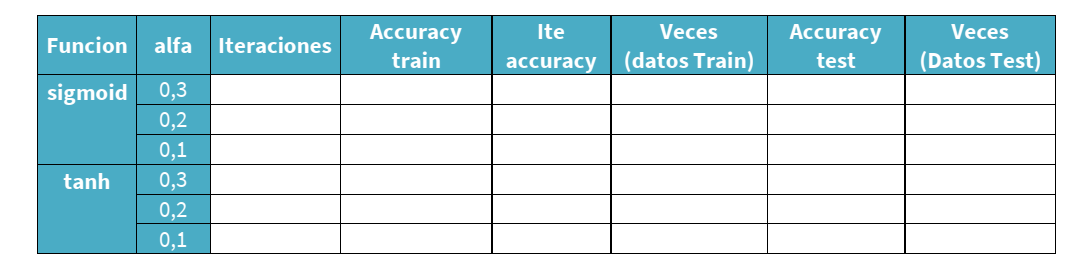


In [ ]:
import pandas as pd      # para trabajar con archivos de datos csv, excel, etc: https://pandas.pydata.org/docs/getting_started/tutorials.html
import chardet           # para detectar la codificación de texto en archivos
import numpy as np
from google.colab import data_table

from sklearn import preprocessing, model_selection
from matplotlib import pyplot as plt

# importa neurona lineal de Laura en la carpeta Colab definida con FUENTES_DIR
from ClassNeuronaGral import NeuronaGradiente


data_table.enable_dataframe_formatter()


nombre_archivo = DATOS_DIR + 'Semillas.csv' # archivo de hojas

#-- detectando la codificación de caracteres usada ----
with open(nombre_archivo, 'rb') as f:
    result = chardet.detect(f.read())  # or readline if the file is large

# recupera el archivo en un objeto dataframe de pandas utilizando la codificación detectada
df = pd.read_csv(nombre_archivo, encoding=result['encoding'])
df

Area  Perimetro  Compacidad  LongNucleo  AnchoNucleo  Asimetria  \
0    15.26      14.84      0.8710       5.763        3.312      2.221   
1    14.88      14.57      0.8811       5.554        3.333      1.018   
2    14.29      14.09      0.9050       5.291        3.337      2.699   
3    13.84      13.94      0.8955       5.324        3.379      2.259   
4    16.14      14.99      0.9034       5.658        3.562      1.355   
..     ...        ...         ...         ...          ...        ...   
205  12.19      13.20      0.8783       5.137        2.981      3.631   
206  11.23      12.88      0.8511       5.140        2.795      4.325   
207  13.20      13.66      0.8883       5.236        3.232      8.315   
208  11.84      13.21      0.8521       5.175        2.836      3.598   
209  12.30      13.34      0.8684       5.243        2.974      5.637   

     LongSurco  Clase  
0        5.220  Tipo1  
1        4.956  Tipo1  
2        4.825  Tipo1  
3        4.805  Tipo1  
4        5.175  Tipo1  
..         ...    ...  
205      4.870  Tipo3  
206      5.003  Tipo3  
207      5.056  Tipo3  
208      5.044  Tipo3  
209      5.063  Tipo3  

[210 rows x 8 columns]

##Selección de atributos y normalización

In [ ]:
X_raw = np.array(df.iloc[:,0:-1])  # recupera todas las columnas salvo la última (es la clase)
T_raw = np.array(df.iloc[:,-1])    # recupera solo la última columna (es la clase)

clases = np.unique(T_raw)  # obtiene las clases sin repeticiones
print('Las clases del dataset son :', clases)

# Normalizacion con media y desviacion
scaler = preprocessing.StandardScaler()
# scaler = preprocessing.MinMaxScaler()
X = scaler.fit_transform(X_raw)

Las clases del dataset son : ['Tipo1' 'Tipo2' 'Tipo3']


##Entrenamiento de modelos para cada una de las clases

In [ ]:
###############################################################################
# neurona no lineal sigmoid
ERROR = 1e-03
ALFA = 0.2
FUN = 'sigmoid'
MAX_ITE = 250

print('\nNeurona con %s' %FUN)

# hace entrenamiento por cada clase
for cls_name in clases:
    # Establece resultado esperado según la clase. 1=clase esperada, 0=otra clase

    T = 1 * (T_raw == cls_name)

    # Entrena perceptrón
    modelo = NeuronaGradiente(alpha=ALFA, n_iter=MAX_ITE, FUN=FUN, cotaE=ERROR)
    modelo.fit(X, T)
    (W, b, iteraciones) = (modelo.w_, modelo.b_, len(modelo.errors_))

    Y = modelo.predict(X)

    efectividad = 100.0*np.sum(Y==T)/len(Y)

    print("Clase %s con %6.2f%% de efectividad con %d iteraciones" % (cls_name, efectividad, iteraciones ))




Neurona con sigmoid
Clase Tipo1 con  93.33% de efectividad con 250 iteraciones
Clase Tipo2 con  99.52% de efectividad con 250 iteraciones
Clase Tipo3 con  97.62% de efectividad con 250 iteraciones


##Entrenamiento para clases del "Tipo 2" con **NeuronaGradiente**

In [ ]:
###############################################################################
# neurona no lineal tanh
ERROR = 1e-03
ALFA = 0.2
FUN = 'sigmoid'
MAX_ITE = 300
CORRIDAS = 30
TEST_SIZE = .4

print('\nNeurona con %s' %FUN)

cls_name = 'Tipo2'
prom_ite = 0
prom_acc_train = 0
prom_acc_test = 0
veces_train = 0
veces_test = 0

if (FUN == 'tanh'):
    T = 2*(T_raw==cls_name)-1
else:
    T = (T_raw==cls_name)*1

for nro_ite in range(CORRIDAS):
    # Establece resultado esperado según la clase. 1=clase esperada, 0=otra clase

    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_raw, T, test_size=TEST_SIZE)#, random_state=42)

    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)

    # Entrena perceptrón
    modelo = NeuronaGradiente(alpha=ALFA, n_iter=MAX_ITE, FUN=FUN, cotaE=ERROR)
    modelo.fit(X_train, Y_train)

    (W, b, iteraciones) = (modelo.w_, modelo.b_, len(modelo.errors_))

    prom_ite = prom_ite + iteraciones

    # efectividad entrenamiento
    Y_pred = modelo.predict(X_train)
    efectividad = 100.0*np.sum(Y_train==Y_pred)/len(Y_pred)
    prom_acc_train = prom_acc_train + efectividad
    if (100-efectividad<0.000001):
        veces_train = veces_train + 1

    print("Clase %s (E) con %6.2f%% de efectividad con %d iteraciones" % (cls_name, efectividad, iteraciones ))

    # efectividad prueba
    Y_pred = modelo.predict(X_test)
    efectividad = 100.0*np.sum(Y_test==Y_pred)/len(Y_pred)
    prom_acc_test = prom_acc_test + efectividad
    if (100-efectividad<0.000001):
        veces_test = veces_test + 1


print('promedio iteraciones  : %6.2f' % (prom_ite/CORRIDAS))
print('promedio acc. train   : %6.2f' % (prom_acc_train/CORRIDAS))
print('promedio acc. test    : %6.2f' % (prom_acc_test/CORRIDAS))
print('ejec. train con 100%%  : %3d' % (veces_train))
print('ejec.  test con 100%%  : %3d' % (veces_test))


Neurona con sigmoid
Clase Tipo2 (E) con  99.21% de efectividad con 300 iteraciones
Clase Tipo2 (E) con 100.00% de efectividad con 300 iteraciones
Clase Tipo2 (E) con  99.21% de efectividad con 300 iteraciones
Clase Tipo2 (E) con 100.00% de efectividad con 300 iteraciones
Clase Tipo2 (E) con  99.21% de efectividad con 234 iteraciones
Clase Tipo2 (E) con 100.00% de efectividad con 300 iteraciones
Clase Tipo2 (E) con 100.00% de efectividad con 300 iteraciones
Clase Tipo2 (E) con 100.00% de efectividad con 166 iteraciones
Clase Tipo2 (E) con 100.00% de efectividad con 300 iteraciones
Clase Tipo2 (E) con 100.00% de efectividad con 230 iteraciones
Clase Tipo2 (E) con  99.21% de efectividad con 300 iteraciones
Clase Tipo2 (E) con  99.21% de efectividad con 300 iteraciones
Clase Tipo2 (E) con 100.00% de efectividad con 202 iteraciones
Clase Tipo2 (E) con  99.21% de efectividad con 300 iteraciones
Clase Tipo2 (E) con  99.21% de efectividad con 300 iteraciones
Clase Tipo2 (E) con 100.00% de efe

## Entrenamiento para clases del "Tipo 2" con **NeuronaGradiente** Modularizado

In [1]:
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
import numpy as np

def entrenar_neurona_no_lineal(
        t_raw, x_raw,
        error=1e-03, alfa=0.2, fun='sigmoid',
        max_ite=200, corridas=30, test_size=0.4,
        scaler=None):
    print('\nNeurona con %s' % fun)
    prom_ite = 0
    prom_acc_train = 0
    prom_acc_test = 0
    veces_train = 0
    veces_test = 0
    for nro_ite in range(corridas):
        # Establece resultado esperado según la clase. 1=clase esperada, 0=otra clase
        x_train, x_test, y_train, y_test = model_selection.train_test_split(x_raw, t_raw, test_size=test_size)
        if scaler is not None:
          x_train = scaler.fit_transform(x_train)
          x_test = scaler.transform(x_test)

        # Entrena perceptrón
        modelo = NeuronaGradiente(alpha=alfa, n_iter=max_ite, FUN=fun, cotaE=error)
        modelo.fit(x_train, y_train)
        w, b, iteraciones = modelo.w_, modelo.b_, len(modelo.errors_)
        prom_ite += iteraciones
        # efectividad entrenamiento
        y_pred = modelo.predict(x_train)
        efectividad = 100.0 * np.sum(y_train == y_pred) / len(y_pred)
        prom_acc_train += efectividad
        if 100 - efectividad < 0.0000001:
            veces_train += 1
        print("Corrida %2d (E): %6.2f%% de efectividad con %d iteraciones" % (nro_ite+1, efectividad, iteraciones))

        # efectividad prueba
        y_pred = modelo.predict(x_test)
        efectividad = 100.0 * np.sum(y_test == y_pred) / len(y_pred)
        prom_acc_test += efectividad
        if 100 - efectividad < 0.0000001:
            veces_test += 1


    print('Promedio iteraciones  : %6.2f' % (prom_ite / corridas))
    print('Promedio acc. train   : %6.2f' % (prom_acc_train / corridas))
    print('Promedio acc. test    : %6.2f' % (prom_acc_test / corridas))
    print('Ejecuciones train con 100%%  : %3d' % (veces_train))
    print('Ejecuciones test con 100%%  : %3d' % (veces_test))


###############################################################################
# neurona no lineal tanh
ERROR = 1e-03
ALFA = 0.2
FUN = 'tanh'
MAX_ITE = 300
CORRIDAS = 30
TEST_SIZE = .4

cls_name = 'Tipo2'
prom_ite = 0
prom_acc_train = 0
prom_acc_test = 0
veces_train = 0
veces_test = 0

if (FUN == 'tanh'):
    T = 2*(T_raw==cls_name)-1
else:
    T = (T_raw==cls_name)*1

scaler = preprocessing.StandardScaler()
# scaler = preprocessing.MinMaxScaler()

# Ejemplo de uso de la función
# Asegúrate de definir T_raw, X_raw, y la clase NeuronaGradiente antes de llamar a la función
entrenar_neurona_no_lineal(T, X_raw,
        error=ERROR, alfa=ALFA, fun=FUN,
        max_ite=MAX_ITE, corridas=CORRIDAS, test_size=TEST_SIZE,
        scaler=scaler)


NameError: name 'T_raw' is not defined